In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin
/kaggle/input/quora-data/quora_test.csv
/kaggle/input/quora-data/quora_train.csv
/kaggle/input/preprocess/clean_train.csv
/kaggle/input/preprocess/test_feature.csv
/kaggle/input/preprocess/clean_test.csv
/kaggle/input/preprocess/train_feature.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
from time import time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K


In [3]:
#train_df = pd.read_csv('/kaggle/input/clean_train.csv')
#test_df = pd.read_csv('/kaggle/input/clean_test.csv')

train_feature_df = pd.read_csv("/kaggle/input/preprocess/train_feature.csv")
test_feature_df = pd.read_csv("/kaggle/input/preprocess/test_feature.csv")

In [ ]:
train_df = pd.read_csv("/kaggle/input/quora-data/quora_train.csv")
test_df = pd.read_csv("/kaggle/input/quora-data/quora_test.csv")

In [5]:
train_df

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,195840,195840,386541,386542,How does banning 500 & 1000 rupee notes solve ...,Will the ban on 500 & 1000 rupee notes really ...,1
1,252241,252241,496583,496584,What is the hardest thing(s) about raising chi...,What is the hardest thing(s) about raising chi...,0
2,249224,249224,490718,490719,Who are Utopia's top competitors?,Who are Axis 41's top competitors?,0
3,125536,125536,248723,248724,I want to improve my reading skill by reading ...,How can reading newspaper help me improve my E...,0
4,390237,390237,762803,762804,How do I gain weight in naturally way?,How to gain weight ?,1
...,...,...,...,...,...,...,...
323475,182164,182164,359776,359777,"Who will win, Trump or Clinton?","Who will be indicted first, Trump or Clinton?",0
323476,280219,280219,550879,550880,Which is the best earphone under 1000rs?,What is the best earphone under 1000 rs?,1
323477,56173,56173,111758,111759,What songs make you cry and why?,Which songs did make you cry ever?,1
323478,231498,231498,456152,456153,Taste of sperm?,What is the taste of sperm?,1


In [6]:
test_df

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,384611,384611,752053,752054,What are the pros and cons of Legalzoom-genera...,Where can I read reviews of LegalZoom?,0
1,258398,258398,508576,508577,Why does ready-to-eat poha absorb water instan...,Ultimate teen patti hacker?,0
2,234932,234932,462847,462848,How apps like paytm earn profit when they are ...,How does Paytm earn by giving extra cash back ...,1
3,347622,347622,681123,681124,What daily habits can greatly upgrade life?,What are your daily habits that improve your p...,1
4,388186,388186,758881,758882,What video game world would you want to live in?,"If you could live in any video game setting, w...",1
...,...,...,...,...,...,...,...
80866,122770,122770,243282,243283,What is your favourite Beatles song and why do...,What is your favorite Beatles song? And why do...,1
80867,276763,276763,544162,544163,Who has the legal authority to rule China's cl...,How can I prove that every bounded and monoton...,0
80868,348359,348359,682538,682539,What are the best simulator games for android?,Which are some best simulator games on android?,1
80869,150536,150536,297798,297799,How can some people still believe the world is...,Why do some people currently believe the earth...,1


In [7]:
EMBEDDING_FILE = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)


In [8]:
def question_to_word(text):
    ''' Lower the captals
        Preprocess the abbreviation
        Convert question text to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


In [9]:
vocabulary_dict = dict()
inv_vocab_dict = ['<unk>']  # for the [0, 0, ....0] embedding
stops = set(stopwords.words('english'))

def word_to_number(dataset):
    out = dataset.copy()
    for row_index, row in dataset.iterrows():
        
        for question_index in ['question1','question2']:
            
            q = []
            for word in question_to_word(row[question_index]):
                
                if word in stops and word not in word2vec.vocab:
                    continue
                    
                if word not in vocabulary_dict:
                    vocabulary_dict[word] = int(len(inv_vocab_dict))
                    q.append(int(len(inv_vocab_dict)))
                    inv_vocab_dict.append(word)
                else:
                    q.append(vocabulary_dict[word])
                out.at[row_index, question_index] = q
    return out
train_df = word_to_number(train_df)
test_df = word_to_number(test_df)


clean train and test

In [10]:
train_drop_index = []
clean_train_df = train_df.copy()

for row_index in range(len(train_df)):
    if (type(train_df.question1[row_index]) == str):
        train_drop_index.append(row_index)
        clean_train_df.question1[row_index] = [0]
    else:
        for ele_index in range(len(train_df.question1[row_index])):
            if(train_df.question1[row_index][ele_index] >= 0 and train_df.question1[row_index][ele_index]< len(inv_vocab_dict)+1):
                continue
            else:
                train_drop_index.append(row_index)
                clean_train_df.question1[row_index] = [0]
    if (row_index%50000 == 0):
        print(row_index)
        

0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


50000
100000
150000
200000
250000
300000


In [11]:
for row_index in range(len(train_df)):
    if (type(train_df.question2[row_index]) == str):
        train_drop_index.append(row_index)
        clean_train_df.question2[row_index] = [0]
    else:
        for ele_index in range(len(train_df.question2[row_index])):
            if(train_df.question2[row_index][ele_index] >= 0 and train_df.question2[row_index][ele_index]< len(inv_vocab_dict)+1):
                continue
            else:
                train_drop_index.append(row_index)
                clean_train_df.question2[row_index] = [0]
    if (row_index%50000 == 0):
        print(row_index)
        

0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


50000
100000
150000
200000
250000
300000


In [12]:
test_drop_index = []
clean_test_df = test_df.copy()

for row_index in range(len(test_df)):
    if (type(test_df.question1[row_index]) == str):
        test_drop_index.append(row_index)
        clean_test_df.question1[row_index] = [0]
    else:
        for ele_index in range(len(test_df.question1[row_index])):
            if(test_df.question1[row_index][ele_index] >= 0 and test_df.question1[row_index][ele_index]< len(inv_vocab_dict)+1):
                continue
            else:
                test_drop_index.append(row_index)
                clean_test_df.question1[row_index] = [0]
    if (row_index%10000 == 0):
        print(row_index)
        

0
10000
20000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


30000
40000
50000
60000
70000
80000


In [13]:
for row_index in range(len(test_df)):
    if (type(test_df.question2[row_index]) == str):
        test_drop_index.append(row_index)
        clean_test_df.question2[row_index] = [0]
    else:
        for ele_index in range(len(test_df.question2[row_index])):
            if(test_df.question2[row_index][ele_index] >= 0 and test_df.question2[row_index][ele_index]< len(inv_vocab_dict)+1):
                continue
            else:
                test_drop_index.append(row_index)
                clean_test_df.question2[row_index] = [0]
    if (row_index%10000 == 0):
        print(row_index)
        

0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


10000
20000
30000
40000
50000
60000
70000
80000


In [14]:
clean_train_df

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,195840,195840,386541,386542,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[12, 13, 14, 15, 4, 5, 6, 7, 16, 17, 18, 19]",1
1,252241,252241,496583,496584,"[20, 21, 13, 22, 23, 24, 25, 26, 27, 28, 29]","[20, 21, 13, 22, 23, 24, 25, 26, 27, 28, 30]",0
2,249224,249224,490718,490719,"[31, 32, 33, 34, 35]","[31, 32, 36, 37, 34, 35]",0
3,125536,125536,248723,248724,"[38, 39, 40, 41, 42, 43, 44, 42, 45, 46, 47, 4...","[1, 53, 42, 54, 55, 56, 40, 41, 45]",0
4,390237,390237,762803,762804,"[1, 57, 38, 58, 59, 28, 60, 61]","[1, 58, 59]",1
...,...,...,...,...,...,...,...
323475,182164,182164,359776,359777,"[31, 12, 340, 657, 51, 662]","[31, 12, 161, 6339, 128, 657, 51, 662]",0
323476,280219,280219,550879,550880,"[72, 21, 13, 121, 5574, 442, 14346]","[20, 21, 13, 121, 5574, 442, 5, 443]",1
323477,56173,56173,111758,111759,"[20, 1712, 311, 74, 6590, 71]","[72, 1712, 522, 311, 74, 6590, 462]",1
323478,231498,231498,456152,456153,"[6316, 2189]","[20, 21, 13, 6316, 2189]",1


In [15]:
clean_test_df

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,384611,384611,752053,752054,"[20, 32, 13, 3608, 3609, 60990, 142, 5020, 53328]","[466, 53, 38, 148, 672, 60990]",0
1,258398,258398,508576,508577,"[71, 2, 1159, 142, 142, 118, 77903, 21214, 938...","[472, 4759, 70746, 4026]",0
2,234932,234932,462847,462848,"[1, 531, 431, 6148, 273, 1037, 65, 826, 32, 37...","[1, 2, 6148, 273, 44, 3776, 3081, 1497, 1059, ...",1
3,347622,347622,681123,681124,"[20, 2786, 2400, 53, 26554, 2045, 109]","[20, 32, 66, 2786, 2400, 112, 40, 66, 12697, 3...",1
4,388186,388186,758881,758882,"[20, 3394, 1137, 132, 300, 74, 39, 191, 28]","[158, 74, 504, 191, 28, 377, 3394, 1137, 4698,...",1
...,...,...,...,...,...,...,...
80866,122770,122770,243282,243283,"[20, 21, 66, 73, 8660, 70, 71, 57, 74, 431, 183]","[20, 21, 66, 67, 8660, 70, 71, 57, 74, 431, 183]",1
80867,276763,276763,544162,544163,"[31, 382, 13, 145, 2842, 3205, 959, 1002, 112,...","[1, 53, 38, 2701, 112, 47, 37275, 86019, 4608,...",0
80868,348359,348359,682538,682539,"[20, 32, 13, 121, 15670, 2430, 139, 2046]","[72, 32, 84, 121, 15670, 2430, 15, 2046]",1
80869,150536,150536,297798,297799,"[1, 53, 84, 217, 422, 1008, 13, 132, 21, 185]","[71, 57, 84, 217, 4123, 1008, 13, 857, 21, 185]",1


In [16]:
embed_matrix = 1 * np.random.randn(len(vocabulary_dict) + 1, 300)
embed_matrix[0] = 0

for vocab, index in vocabulary_dict.items():
    if vocab in word2vec.vocab:
        embed_matrix[index] = word2vec.word_vec(vocab)

del word2vec


In [17]:
train_feature_df

,id,qid1,qid2,word_match,q1_q2_intersect,is_duplicate,tfidf_word_match
0,195840,386541,386542,0.526316,19,1,1.0
1,252241,496583,496584,0.833333,0,0,1.0
2,249224,490718,490719,0.666667,0,0,1.0
3,125536,248723,248724,0.421053,0,0,1.0
4,390237,762803,762804,0.750000,15,1,1.0
...,...,...,...,...,...,...,...
323475,182164,359776,359777,0.727273,0,0,1.0
323476,280219,550879,550880,0.666667,8,1,1.0
323477,56173,111758,111759,0.888889,3,1,1.0
323478,231498,456152,456153,1.000000,0,1,1.0


In [18]:
test_feature_df

,test_id,word_match,q1_q2_intersect,tfidf_word_match,question1,question2,qid1,qid2
0,384611,0.400000,0,1.0,What are the pros and cons of Legalzoom-genera...,Where can I read reviews of LegalZoom?,752053,752054
1,258398,0.166667,0,1.0,Why does ready-to-eat poha absorb water instan...,Ultimate teen patti hacker?,508576,508577
2,234932,0.571429,3,1.0,How apps like paytm earn profit when they are ...,How does Paytm earn by giving extra cash back ...,462847,462848
3,347622,0.500000,1,1.0,What daily habits can greatly upgrade life?,What are your daily habits that improve your p...,681123,681124
4,388186,0.666667,2,1.0,What video game world would you want to live in?,"If you could live in any video game setting, w...",758881,758882
...,...,...,...,...,...,...,...,...
80866,122770,0.800000,0,1.0,What is your favourite Beatles song and why do...,What is your favorite Beatles song? And why do...,243282,243283
80867,276763,0.080000,0,1.0,Who has the legal authority to rule China's cl...,How can I prove that every bounded and monoton...,544162,544163
80868,348359,1.000000,0,1.0,What are the best simulator games for android?,Which are some best simulator games on android?,682538,682539
80869,150536,0.666667,16,1.0,How can some people still believe the world is...,Why do some people currently believe the earth...,297798,297799


In [19]:
clean_train_df['word_match'] = train_feature_df['word_match']
clean_train_df['intersect'] = train_feature_df['q1_q2_intersect']
clean_train_df['tfidf'] = train_feature_df['tfidf_word_match']


clean_test_df['word_match'] = test_feature_df['word_match']
clean_test_df['intersect'] = test_feature_df['q1_q2_intersect']
clean_test_df['tfidf'] = test_feature_df['tfidf_word_match']


In [20]:
X_train = clean_train_df[['question1', 'question2','word_match','intersect','tfidf']]
Y_train = clean_train_df['is_duplicate']

X_train = {'q1': X_train.question1,'q2':X_train.question2,
           'wm':X_train.word_match,'intersect':X_train.intersect,'tfidf':X_train.tfidf}
Y_train = Y_train.values


In [21]:
X_test = clean_test_df[['question1', 'question2','word_match','intersect','tfidf']]
Y_test = clean_test_df['is_duplicate']

X_test = {'q1': X_test.question1,'q2':X_test.question2,
           'wm':X_test.word_match,'intersect':X_test.intersect,'tfidf':X_test.tfidf}
Y_test = Y_test.values


In [22]:
length11 = max(clean_train_df.question1.map(lambda x: len(x)))
length12 = max(clean_train_df.question2.map(lambda x: len(x)))

length21 = max(clean_test_df.question1.map(lambda x: len(x)))
length22 = max(clean_test_df.question2.map(lambda x: len(x)))
max_length = max(length11, length12, length21, length22)


In [23]:
max_length

212

In [24]:

X_train['q1'] = pad_sequences(X_train['q1'], maxlen=max_length)
X_train['q2'] = pad_sequences(X_train['q2'], maxlen=max_length)
X_test['q1'] = pad_sequences(X_test['q1'], maxlen=max_length)
X_test['q2'] = pad_sequences(X_test['q2'], maxlen=max_length)


In [25]:
def exp_neg_manhatten_dist(q1, q2):
    distance = K.exp(-K.sum(K.abs(q1 - q2),axis = 1, keepdims = True))
    return distance


In [26]:
from keras import layers

In [27]:
# Model variables
n_hidden = 50
batch_size = 64
n_epoch = 25
embedding_dim = 300
max_length = 212

input_q1 = Input(shape = (max_length,), dtype = 'int32')
input_q2 = Input(shape = (max_length,), dtype = 'int32')
input_wordmatch = Input(shape = (1,), dtype = 'float32')
input_intersect = Input(shape = (1,), dtype = 'float32')
input_tfidf = Input(shape = (1,), dtype = 'float32')


embedding_layer = Embedding(len(embed_matrix), embedding_dim,
                           weights = [embed_matrix],
                           input_length = max_length, trainable = False)
embedded_q1 = embedding_layer(input_q1)
embedded_q2 = embedding_layer(input_q2)

shared_lstm = LSTM(n_hidden)

output_q1 = shared_lstm(embedded_q1)
output_q2 = shared_lstm(embedded_q2)

manhatten_lstm_distance = Lambda(function = lambda x:exp_neg_manhatten_dist(x[0],x[1]),
                        output_shape = lambda x:(x[0][0], 1))([output_q1,output_q2])


concatenated = layers.concatenate([manhatten_lstm_distance, input_wordmatch, input_intersect,input_tfidf], axis = -1)
input_1 = layers.Dense(8, activation = 'relu')(concatenated)
drop_out_1 = layers.Dropout(0.5)(input_1)
hidden_1 = layers.Dense(4, activation = 'relu')(drop_out_1)
drop_out_2 = layers.Dropout(0.5)(hidden_1)
output = layers.Dense(1, activation = 'sigmoid')(drop_out_2)

model = Model([input_q1, input_q2,input_wordmatch,input_intersect,input_tfidf],[output])

model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['binary_accuracy'])

                       
#manhatten_lstm.compile(loss = 'categorical_crossentropy',optimizer = 'rmsprop',metrics = ['accuracy'])
#manhatten_lstm.summary()

binary he categorical 值得一写!!!

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 212)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 212)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 212, 300)     25806300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 50)           70200       embedding[0][0]              

In [29]:
training_start_time = time()
model_trained = model.fit([X_train['q1'], X_train['q2'],X_train['wm'],X_train['intersect'],X_train['tfidf']], Y_train,
                                            validation_split = 0.1,
                                            batch_size=batch_size, epochs = n_epoch)

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))


Epoch 1/25
4549/4549 [==============================] - 136s 30ms/step - loss: 0.4761 - binary_accuracy: 0.7879 - val_loss: 0.3328 - val_binary_accuracy: 0.8629
Epoch 2/25
4549/4549 [==============================] - 136s 30ms/step - loss: 0.4101 - binary_accuracy: 0.8236 - val_loss: 0.3075 - val_binary_accuracy: 0.8735
Epoch 3/25
4549/4549 [==============================] - 135s 30ms/step - loss: 0.3978 - binary_accuracy: 0.8321 - val_loss: 0.2931 - val_binary_accuracy: 0.8768
Epoch 4/25
4549/4549 [==============================] - 135s 30ms/step - loss: 0.3911 - binary_accuracy: 0.8373 - val_loss: 0.2906 - val_binary_accuracy: 0.8807
Epoch 5/25
4549/4549 [==============================] - 135s 30ms/step - loss: 0.3876 - binary_accuracy: 0.8398 - val_loss: 0.2884 - val_binary_accuracy: 0.8794
Epoch 6/25
4549/4549 [==============================] - 136s 30ms/step - loss: 0.3802 - binary_accuracy: 0.8451 - val_loss: 0.2836 - val_binary_accuracy: 0.8820
Epoch 8/25
4549/4549 [============

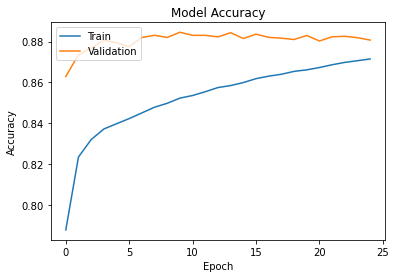

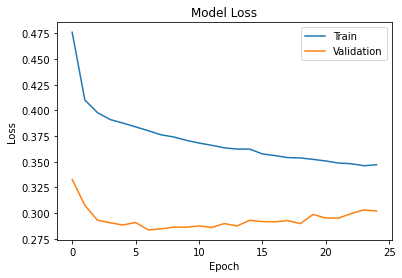

<Figure size 432x288 with 0 Axes>

In [30]:
# Plot accuracy
plt.plot(model_trained.history['binary_accuracy'])
plt.plot(model_trained.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('acc.png')

# Plot loss
plt.plot(model_trained.history['loss'])
plt.plot(model_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.savefig('loss.png')


In [31]:
results = model.evaluate([X_test['q1'], X_test['q2'],X_test['wm'],X_test['intersect'],X_test['tfidf']], Y_test)

2528/2528 [==============================] - 28s 11ms/step - loss: 0.2942 - binary_accuracy: 0.8829


In [32]:
y_score = model.predict([X_test['q1'], X_test['q2'],X_test['wm'],X_test['intersect'],X_test['tfidf']])

In [36]:
y_score_df = pd.DataFrame(y_score)

In [38]:
y_score_df.to_csv('y_pred.csv',index=False)

In [63]:
i = -1
y_pred_df = y_score_df.copy()

for ele in y_score_df[0]:
    i = i+1
    if ele >= 0.5:
        y_pred_df[0][i] = 1
    else:
        y_pred_df[0][i] = 0
        
y_pred_df

,0
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
80866,1.0
80867,0.0
80868,1.0
80869,1.0


In [64]:
y_pred_df.to_csv('y_predclass.csv',index=False)

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(Y_test, y_score)


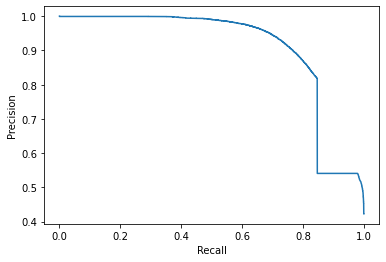

In [41]:
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

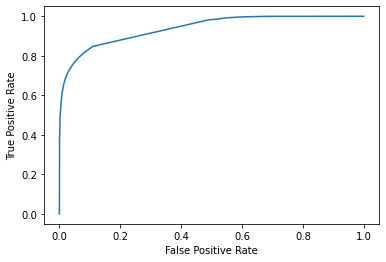

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(Y_test, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

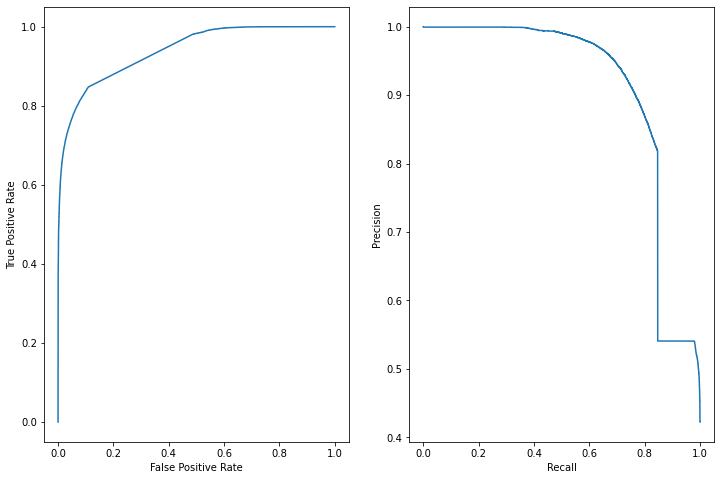

In [43]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [66]:
y_score_df[0]

0        0.069399
1        0.012839
2        0.999981
3        0.732923
4        0.999358
           ...   
80866    0.992587
80867    0.005977
80868    0.743770
80869    1.000000
80870    0.847692
Name: 0, Length: 80871, dtype: float32

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [68]:
# reduce to 1d array
yhat_probs = y_score_df[0]
yhat_classes = y_pred_df[0]
testy = Y_test

In [70]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)
 
# ROC AUC
auc = roc_auc_score(testy, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

Accuracy: 0.882912
Precision: 0.904848
Recall: 0.760976
F1 score: 0.826699
ROC AUC: 0.938986
[[48817  2375]
 [ 7094 22585]]


In [14]:
from sklearn.metrics import average_precision_score
average_precision_score(Y_test, y_score)

0.9069859164894829